In [1]:
import os 
import sys
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-whitegrid')#绘图的主题
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Masking,Dropout



C:\Users\chao\AppData\Local\Temp\ipykernel_67700\3361909688.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')#绘图的主题


In [2]:
# Setting seed for reproducibility


# Input files don't have column names
dependent_var = ['RUL']#依赖的变量
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]#添加操作条件1,2,3,
sensor_measure_columns_names =["Sensor"+str(i) for i in range(1,22)]#添加传感器编号1，…，21
#输入发动机编号/运行时间/设置/哪个传感器数据/
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names


In [3]:
## 读取训练集
#pandas读取数据/True:以，为分割符/names:指定列名
df_train = pd.read_csv('E:\研究资料\Remaining-Useful-Life-Estimation-Variational-main\data/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
df_train['RUL'] = df_train['max'] - df_train['Cycle']
#然后在把最大的max去掉
df_train.drop('max', axis=1, inplace=True)

df_train

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [4]:
## 读取测试集
df_test = pd.read_csv('E:\研究资料\Remaining-Useful-Life-Estimation-Variational-main\data/test_FD001.txt',delim_whitespace=True,names=input_file_column_names)
"""为了方便测试集的每一个unit的可视化，需要给测试集算出真实的RUL列值"""
rul = pd.DataFrame(df_test.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_test = df_test.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
"""此时还不是真实剩余RUL"""
df_test['RUL'] = df_test['max'] - df_test['Cycle']
#然后在把最大的max去掉
df_test.drop('max', axis=1, inplace=True)


In [5]:
y_true = pd.read_csv('E:\研究资料\Remaining-Useful-Life-Estimation-Variational-main\data/RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
"""注意：这里UnitNumber=1=测试集的UnitNumber"""
y_true["UnitNumber"] = y_true.index+1



In [6]:
"""首先制作以UnitNumber为ID的真是RUL的DataFrame"""
actual_rul = pd.DataFrame(y_true.groupby('UnitNumber')['RUL'].max()).reset_index()
actual_rul.columns = ['UnitNumber', 'acrul']
df_test = df_test.merge(actual_rul, on=['UnitNumber'], how='left')
df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL,acrul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,4,20
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,3,20
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,2,20
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,1,20


In [7]:
"""最终才是真实的测试集RUL"""
df_test['RUL'] = df_test['RUL']+df_test['acrul']
#然后在把最大的acrul去掉
df_test.drop('acrul', axis=1, inplace=True)
df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [8]:
#分段线性化处理
def fun(x):
    if x >= 125:
        return 125
    else:
        return x

In [9]:
df_test['RUL']=df_test['RUL'].apply(lambda x: fun(x))
df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,125
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,125
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,125
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,125
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [10]:
y_true['RUL']=y_true['RUL'].apply(lambda x: fun(x))
y_true

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,125,96
96,82,97
97,59,98
98,117,99


In [11]:

df_train['RUL']=df_train['RUL'].apply(lambda x: fun(x))
df_train

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,125
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,125
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,125
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


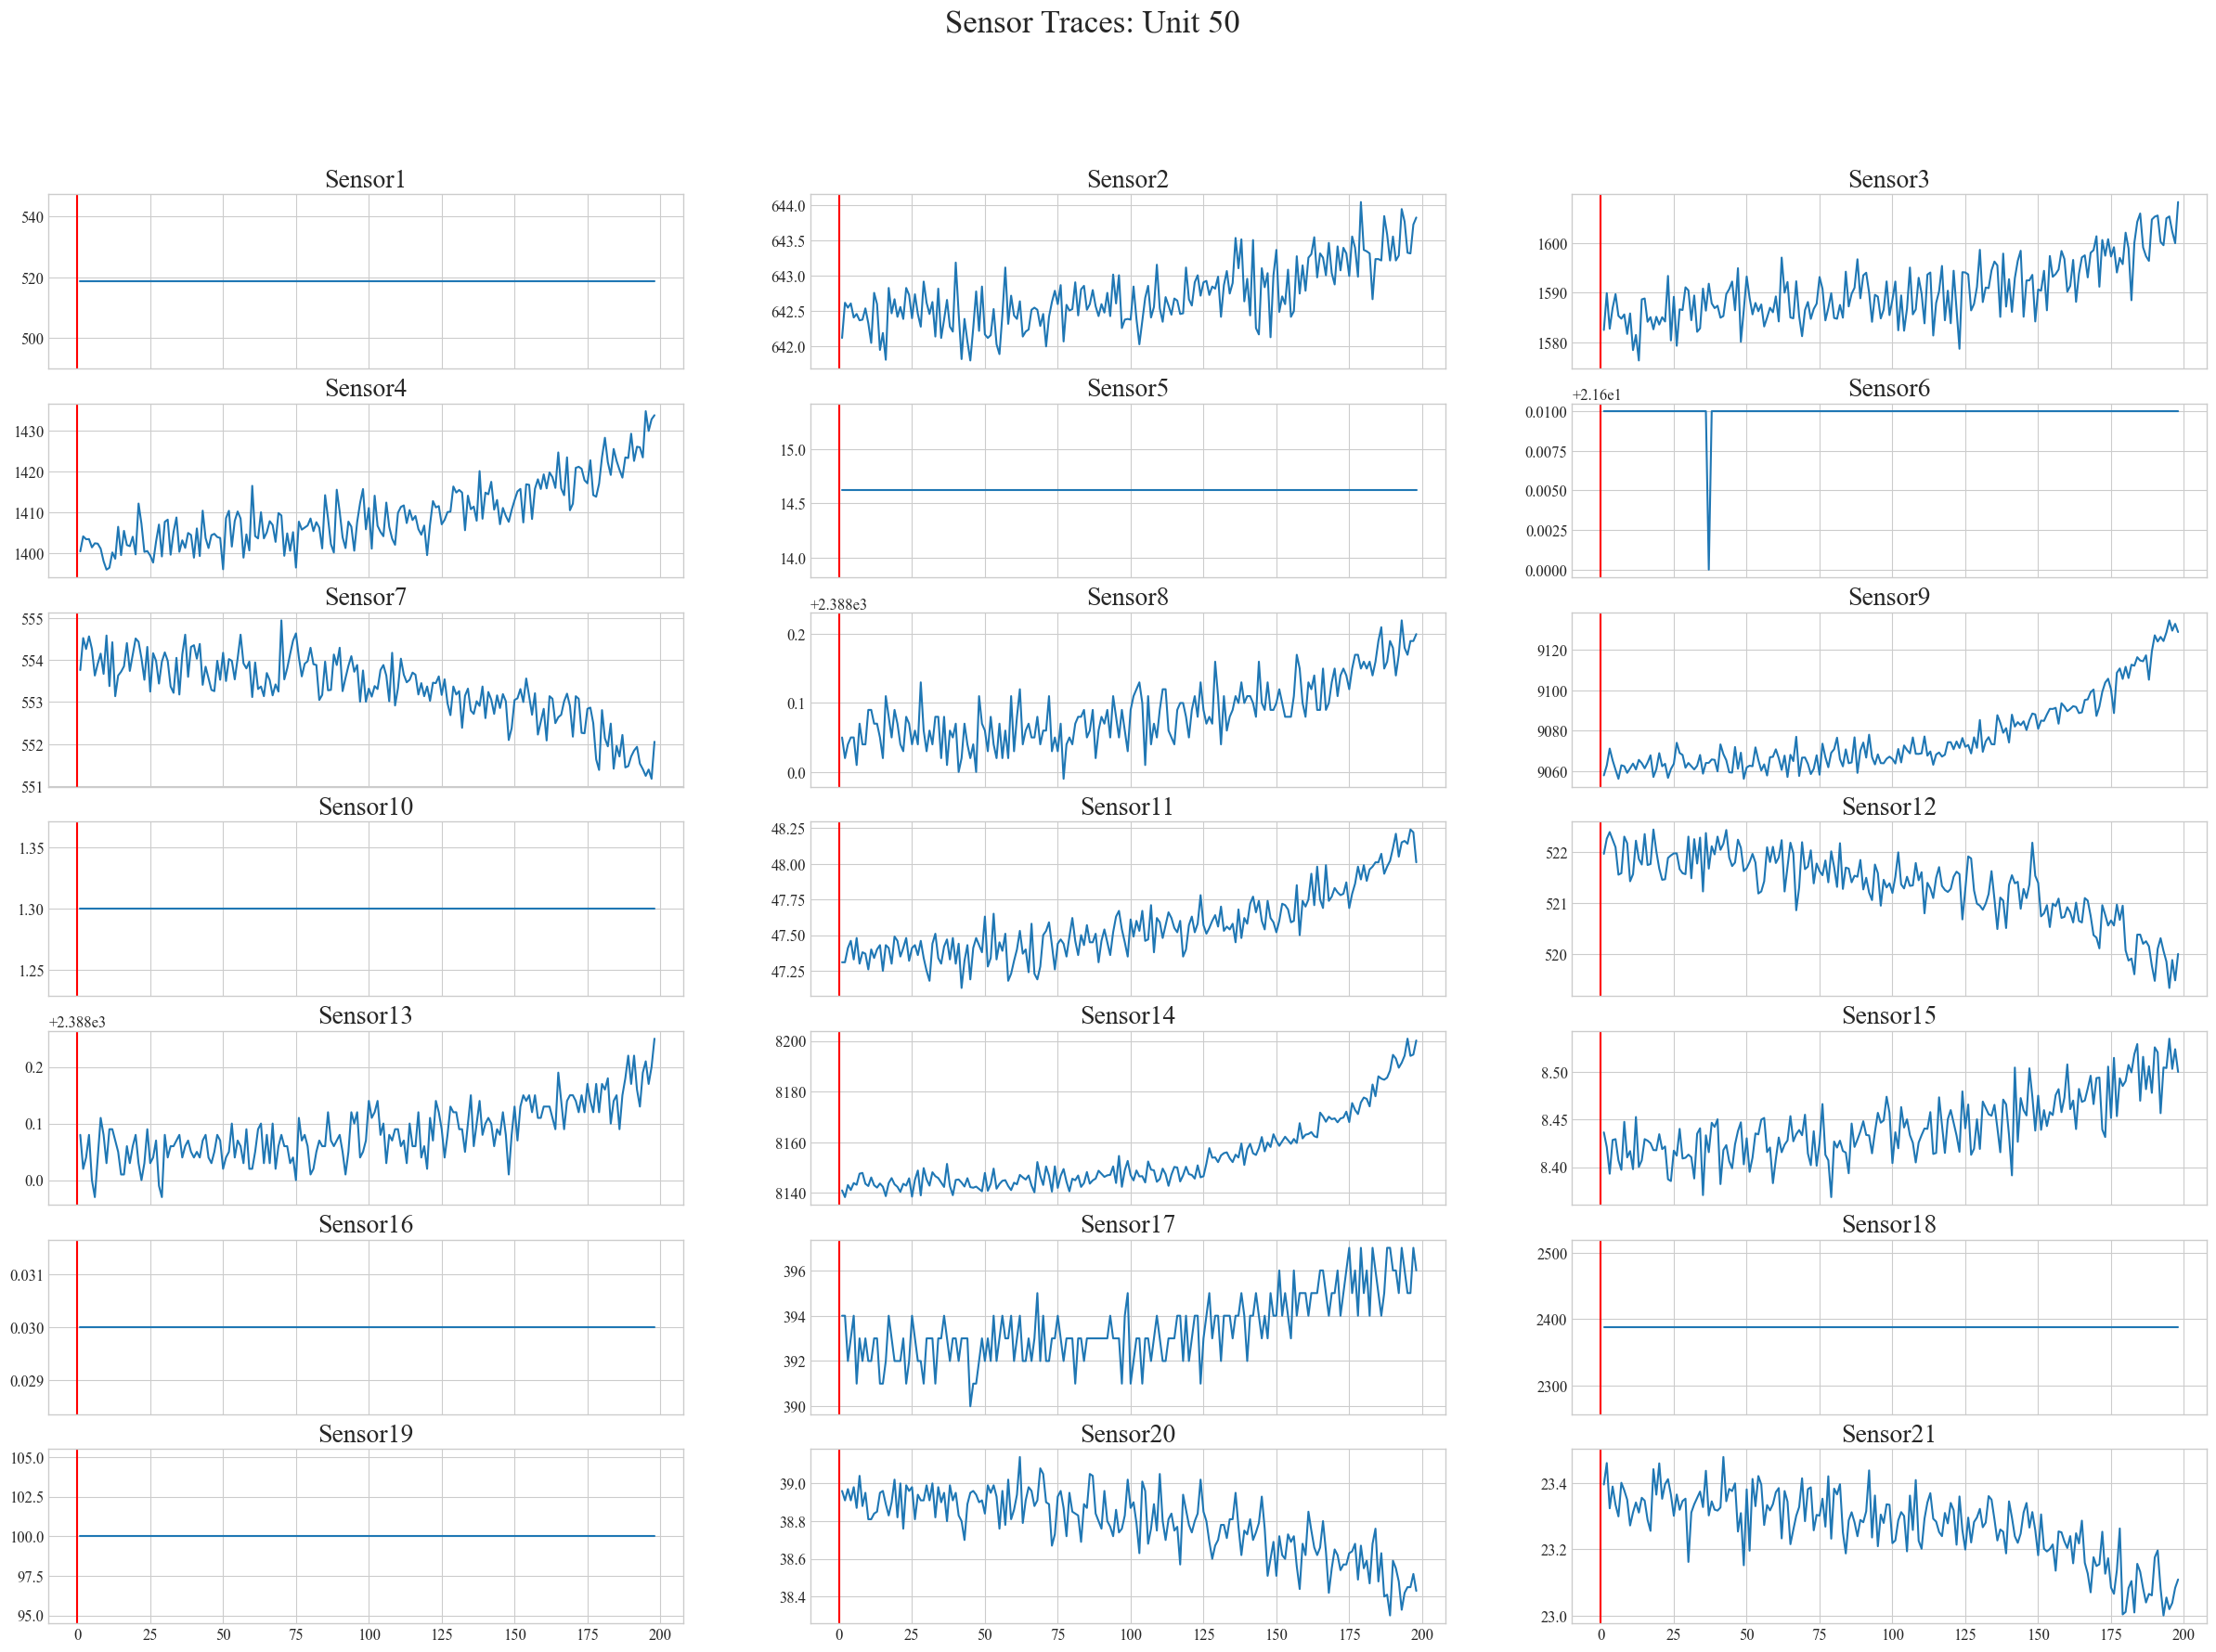

In [12]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==50')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['Sensor'+str(c+1)])
        ax[i,j].set_title('Sensor'+str(c+1),fontsize=20)
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 50',fontsize=25)
plt.show()

In [13]:
### 去除没必要的传单其数据

not_required_feats = ["Sensor1", "Sensor5", "Sensor6", "Sensor10", "Sensor16", "Sensor18", "Sensor19"]
feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]




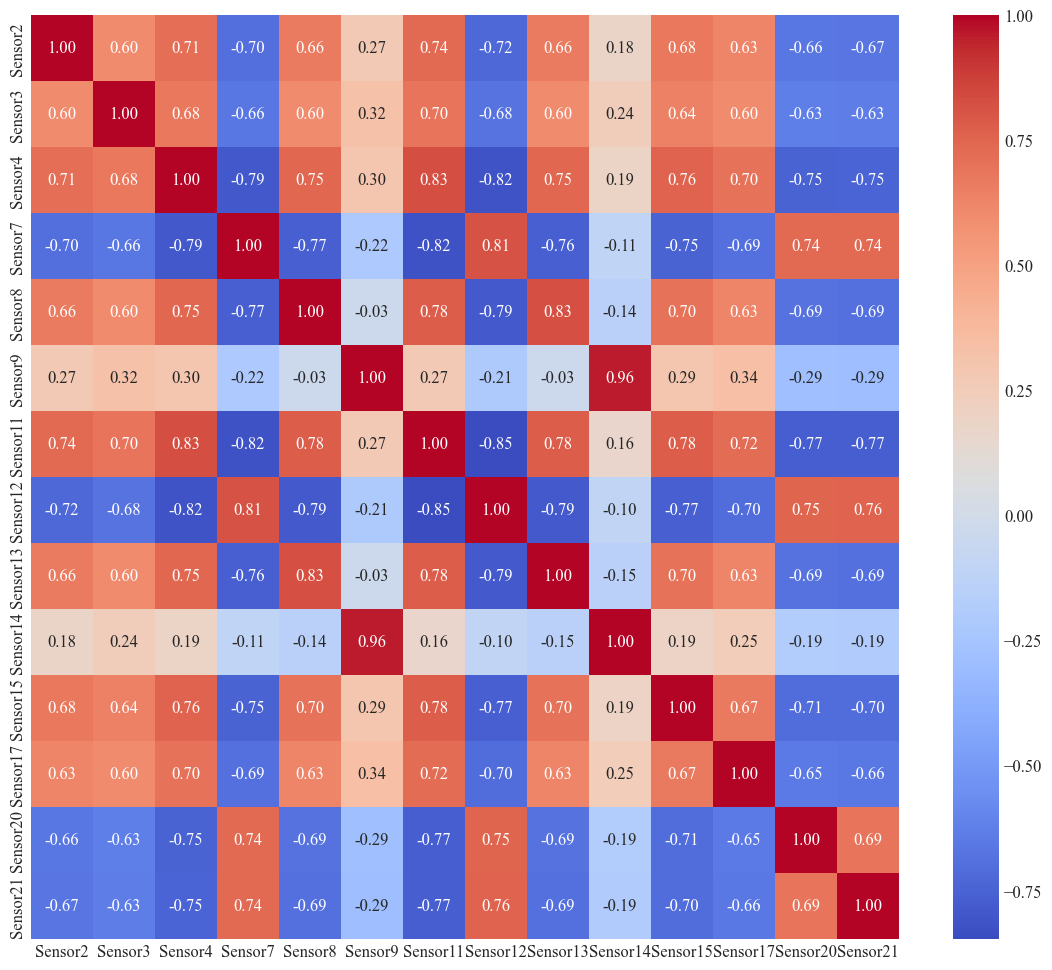

In [14]:
corr = df_train[feats].corr()

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")

In [15]:
# 二.数据处理
sequence_length = 30
mask_value = 0


In [16]:
#MinMaxScaler：归一到 [ 0，1 ] MaxAbsScaler：归一到 [ -1，1 ] 
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))#参数设置为(-1,1)源代码为(0,1)

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [17]:
def gen_train(id_df, seq_length, seq_cols):
 
    data_array = id_df[seq_cols].values
    
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [18]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [19]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [20]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) 
                            for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17731, 30, 14)


In [21]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) 
                              for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17731,)

In [22]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 30, 14)


C:\Users\chao\AppData\Local\Temp\ipykernel_67700\3221920451.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\chao\AppData\Local\Temp\ipykernel_67700\3221920451.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\chao\AppData\Local\Temp\ipykernel_67700\3221920451.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\Users\chao\AppData\Local\Temp\ipykernel_67700\3221920451.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
C:\U

In [23]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [24]:

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)

In [25]:
# import keras.backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error

#自定义评价指标
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

#自定义PHM2008评价函数
def Scoring_2008(Y_true, Y_pred):
    h = Y_pred - Y_true
    g = (-(h-K.abs(h))/2.0)
    f = ((K.abs(h)+h)/2.0)
    return (K.sum(K.exp(g/13.0)-1)+K.sum(K.exp(f/10.0)-1))
    



In [26]:
"""分段学习率"""
def scheduler(epoch):
    if epoch > 200:
        return 0.0001
    else:
        return 0.001
"""打印学习率，方便查看"""
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr#无衰减策略的学习率
    return lr

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False), input_shape=(30,14)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='relu')
])

#查看网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              92000     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 30)                6030      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 98,061
Trainable params: 98,061
Non-trainable params: 0
____________________________________________________

In [28]:
optimizer_diy =tf.keras.optimizers.Adam(learning_rate=0.001)
lr_metric = get_lr_metric(optimizer_diy)

model.compile(optimizer=optimizer_diy,loss='mse',metrics=['mse','mae',RMSE,Scoring_2008,lr_metric]) 


In [29]:
Batch_size=512

In [30]:
History = model.fit(x_train, y_train, epochs=150, batch_size=Batch_size,validation_split=0.20,
                        verbose=2,
            callbacks =[keras.callbacks.EarlyStopping(monitor ='val_loss', min_delta=0,patience=25, verbose=0, mode='min'),
                        keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/150
28/28 - 9s - loss: 6338.7881 - mse: 6338.7881 - mae: 68.6333 - RMSE: 79.0614 - Scoring_2008: 1312301.2500 - lr: 0.0010 - val_loss: 4499.4570 - val_mse: 4499.4570 - val_mae: 56.8193 - val_RMSE: 66.7355 - val_Scoring_2008: 281672.7500 - val_lr: 0.0010 - 9s/epoch - 324ms/step
Epoch 2/150
28/28 - 5s - loss: 2729.6169 - mse: 2729.6169 - mae: 42.5508 - RMSE: 51.7417 - Scoring_2008: 128478.3750 - lr: 0.0010 - val_loss: 1571.6825 - val_mse: 1571.6825 - val_mae: 33.7784 - val_RMSE: 39.4262 - val_Scoring_2008: 17676.3887 - val_lr: 0.0010 - 5s/epoch - 171ms/step
Epoch 3/150
28/28 - 5s - loss: 1479.7029 - mse: 1479.7029 - mae: 31.2343 - RMSE: 38.3797 - Scoring_2008: 96567.9531 - lr: 0.0010 - val_loss: 849.9582 - val_mse: 849.9582 - val_mae: 25.6712 - val_RMSE: 29.0772 - val_Scoring_2008: 9779.1650 - val_lr: 0.0010 - 5s/epoch - 191ms/step
Epoch 4/150
28/28 - 5s - loss: 1228.4583 - mse: 1228.4583 - mae: 28.0000 - RMSE: 35.0403 - Scoring_2008: 170423.2188 - lr: 0.0010 - val_loss: 729.7946

Epoch 31/150
28/28 - 6s - loss: 679.9431 - mse: 679.9431 - mae: 19.4141 - RMSE: 26.0466 - Scoring_2008: 25488.1602 - lr: 0.0010 - val_loss: 320.3848 - val_mse: 320.3848 - val_mae: 14.3587 - val_RMSE: 17.7201 - val_Scoring_2008: 2142.9456 - val_lr: 0.0010 - 6s/epoch - 198ms/step
Epoch 32/150
28/28 - 7s - loss: 684.8258 - mse: 684.8258 - mae: 19.6340 - RMSE: 26.1439 - Scoring_2008: 25755.7363 - lr: 0.0010 - val_loss: 277.2508 - val_mse: 277.2508 - val_mae: 13.8060 - val_RMSE: 16.6112 - val_Scoring_2008: 1820.2656 - val_lr: 0.0010 - 7s/epoch - 234ms/step
Epoch 33/150
28/28 - 5s - loss: 673.6129 - mse: 673.6129 - mae: 19.4297 - RMSE: 25.9400 - Scoring_2008: 26882.2656 - lr: 0.0010 - val_loss: 283.1111 - val_mse: 283.1111 - val_mae: 13.8807 - val_RMSE: 16.7563 - val_Scoring_2008: 1729.9843 - val_lr: 0.0010 - 5s/epoch - 184ms/step
Epoch 34/150
28/28 - 5s - loss: 655.1594 - mse: 655.1594 - mae: 19.1614 - RMSE: 25.5604 - Scoring_2008: 26177.2012 - lr: 0.0010 - val_loss: 283.2027 - val_mse: 283

Epoch 61/150
28/28 - 6s - loss: 615.3709 - mse: 615.3709 - mae: 18.4189 - RMSE: 24.7792 - Scoring_2008: 41055.1562 - lr: 0.0010 - val_loss: 250.5582 - val_mse: 250.5582 - val_mae: 12.7163 - val_RMSE: 15.7361 - val_Scoring_2008: 1596.7020 - val_lr: 0.0010 - 6s/epoch - 214ms/step
Epoch 62/150
28/28 - 5s - loss: 597.6604 - mse: 597.6604 - mae: 18.1342 - RMSE: 24.4171 - Scoring_2008: 24984.6211 - lr: 0.0010 - val_loss: 219.6708 - val_mse: 219.6708 - val_mae: 11.8654 - val_RMSE: 14.7182 - val_Scoring_2008: 1469.8915 - val_lr: 0.0010 - 5s/epoch - 174ms/step
Epoch 63/150
28/28 - 5s - loss: 607.8020 - mse: 607.8020 - mae: 18.2577 - RMSE: 24.6284 - Scoring_2008: 15970.7139 - lr: 0.0010 - val_loss: 293.1585 - val_mse: 293.1585 - val_mae: 13.3534 - val_RMSE: 16.9859 - val_Scoring_2008: 1861.7969 - val_lr: 0.0010 - 5s/epoch - 168ms/step
Epoch 64/150
28/28 - 5s - loss: 614.5803 - mse: 614.5803 - mae: 18.3041 - RMSE: 24.7798 - Scoring_2008: 25508.4707 - lr: 0.0010 - val_loss: 259.2230 - val_mse: 259

In [34]:
def plotTrainHistory(model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()

dict_keys(['loss', 'mse', 'mae', 'RMSE', 'Scoring_2008', 'lr', 'val_loss', 'val_mse', 'val_mae', 'val_RMSE', 'val_Scoring_2008', 'val_lr'])


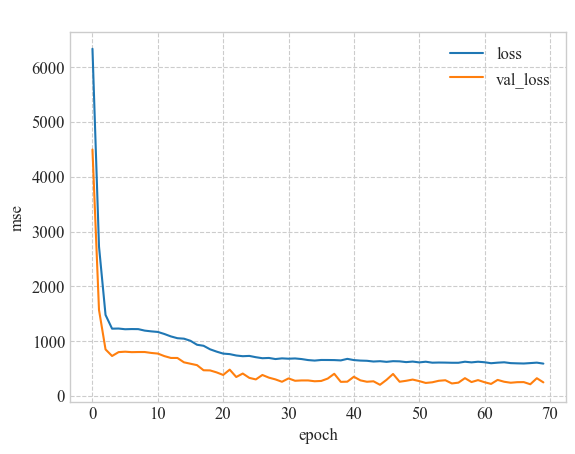

In [35]:
print(History.history.keys())
plotTrainHistory(History)

In [36]:
import sys
sys.path.append('E:\study\复现资料\RUL-RVE\SIMPAC-2022-58-main')
import utils

y_hat_train = model.predict(x_train)
y_hat_test = model.predict(x_test)

4/4 [==============================] - 0s 7ms/step


In [39]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


def score(y_true, y_hat):
    res = 0
    for true, hat in zip(y_true, y_hat):
        subs = hat - true
        if subs < 0:
            res = res + np.exp(-subs / 13)[0] - 1
        else:
            res = res + np.exp(subs / 10)[0] - 1
    print("score: ", res)


In [40]:
RMSE=evaluate(y_test, y_hat_test, 'test')
score=score(y_test, y_hat_test)

test set RMSE:13.494325955526763, R2:0.8866053189357134
score:  285.8809903860092


In [47]:
model.load_weights(os.path.join(save_dir, 'model_Weights_best.h5py'))

In [48]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])


35/35 [==============================] - 6s 171ms/step - loss: 165.6950 - mse: 165.6950 - mae: 10.2858 - RMSE: 12.6944 - Scoring_2008: 11.8339 - lr: 1.0000e-03


In [49]:
df

,MSE,MAE,RMSE,Scoring_2008
0,165.695038,10.28584,12.694375,11.833885


In [50]:
scores = model.evaluate(x_test,y_test, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])
df

1/1 [==============================] - 0s 244ms/step - loss: 168.3779 - mse: 168.3779 - mae: 9.8968 - RMSE: 12.9761 - Scoring_2008: 2.6196 - lr: 0.0010


,MSE,MAE,RMSE,Scoring_2008
0,168.37793,9.896838,12.976052,2.619588


In [51]:
y_pred_test = model.predict(x_test,verbose=2)
y_true_test = y_test.reshape(y_test.shape[0],1).astype(np.float32)

4/4 - 0s - 157ms/epoch - 39ms/step


In [52]:
"""保存预测的RUL值与实际的RUL值"""
y_pred_test=y_pred_test.reshape(y_pred_test.shape[0]*y_pred_test.shape[1]).astype(np.float32)
y_true_test=y_true_test.reshape(y_true_test.shape[0]*y_true_test.shape[1]).astype(np.float32)
y_All=pd.DataFrame({'Pre':y_pred_test,
                   'Actual':y_true_test})
y_All.to_csv(save_dir+"y_lastpoint_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

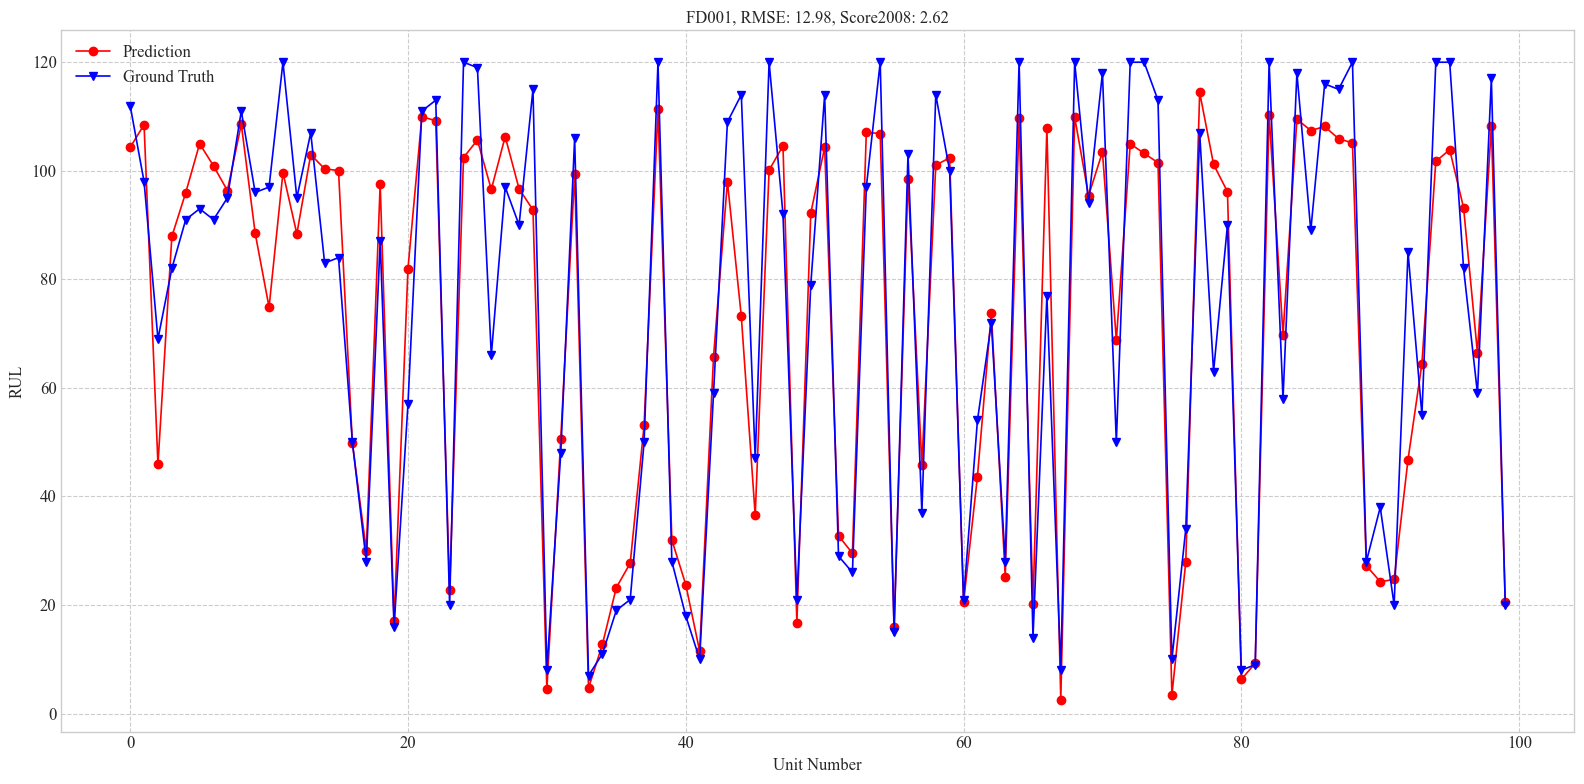

In [53]:
"""测试集所有unitNumber的最后一个值进行可视化"""
from sklearn.metrics import mean_squared_error
rmse = RMSE(y_true_test,y_pred_test)
score_2008 = Scoring_2008(y_true_test,y_pred_test)

fig=plt.figure(figsize=(16,8))
plt.grid(linestyle="--")
plt.plot(y_pred_test, color='red', label='Prediction', marker='o',linestyle='-',linewidth=1.2)
plt.plot(y_true_test, color='blue', label='Ground Truth', marker='v',linestyle='-',linewidth=1.2)
plt.title('FD001'+ ', RMSE: '+str('%.2f' % rmse)+ ', Score2008: '+str('%.2f' % score_2008),fontsize=12)
plt.ylabel('RUL',fontsize=12)
plt.xlabel('Unit Number' ,fontsize=12)
plt.legend(loc='upper left',fontsize=12)
fig.tight_layout()
plt.savefig(save_dir+'FD001_Last_point_Pre.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()

In [42]:
y_All

,Pre,Actual
0,104.304543,112.0
1,108.487709,98.0
2,45.883091,69.0
3,87.891075,82.0
4,95.954269,91.0
...,...,...
95,103.874153,120.0
96,93.186203,82.0
97,66.405663,59.0
98,108.268929,117.0


In [54]:
def RMSE(y_true, y_hat):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    return rmse
RMSE(y_true_test,y_pred_test)

12.976052

In [56]:
def score(y_true, y_hat):
    res = 0
    for true, hat in zip(y_true, y_hat):
        subs = hat - true
        if subs < 0:
            res = res + np.exp(-subs/13)-1
        else:
            res = res + np.exp(subs/10)-1
    return res
score(y_true_test,y_pred_test)

261.9587339833445

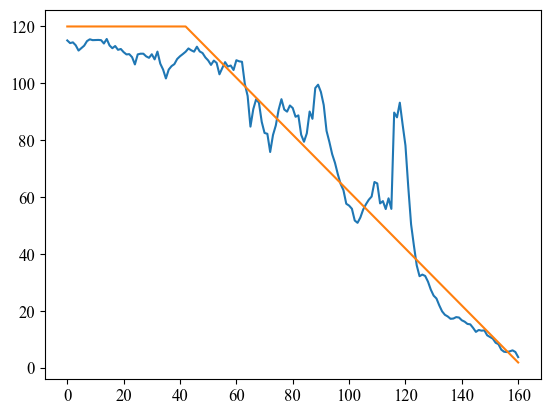

In [44]:
output = model(x_train[0:161]).numpy()   # 将第一个sample放进去
label_array = y_train[0:161]
plt.plot(output)
plt.plot(label_array)
plt.show()


In [45]:
grouped = df_train.groupby('UnitNumber')
train_id1 = grouped.get_group(1)


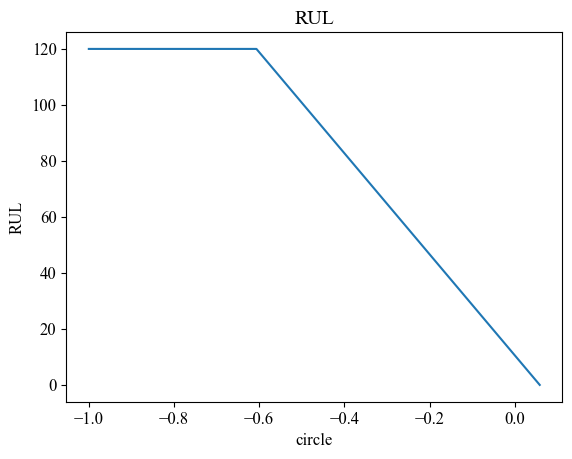

In [46]:
x=np.array(train_id1.Cycle)
y=np.array(train_id1.RUL)
plt.xlabel('circle')
plt.ylabel('RUL')
plt.title('RUL')
plt.plot(x,y)
plt.show()